In [156]:
import os
import sys
import multiprocessing as mp
from time import time

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import ticker
from astropy import units as u
from astropy.constants import c, k_B
from astropy.table import Table

import pyradex
# import pymultinest
import emcee
import corner

In [157]:
_kmps = u.km/u.s
_Jykmps = u.Jy*u.km/u.s
REJECTED = -np.inf

#### Next steps:

1. Fix deltav to 1 and use the linewidth to compute line flux.

1. Add saving capabilities.

1. Allow the output to be normalized to the J=1 flux (and fix the filling factor to 1).

1. Add custom priors (i.e. for mass, luminosity, custom parameter limits, etc) that use the entire radex output.

1. Add in the isotopologue option.

1. Add a second thermal component.

1. Test using pymultinest instead of emcee as it may converge faster. Create child classes for RadexAnalyzer.

In [158]:
def jy_to_kelvin(flux, freq, beam):
    flux = u.Quantity(flux, u.Jy)
    freq = u.Quantity(freq, u.GHz)
    T_B = (c*c/(2*k_B*freq**2*beam)).to(u.K)
    return T_B
    
def kelvin_to_jy(T_B, freq, beam):
    T_B = u.Quantity(T_B, u.K)
    freq = u.Quantity(freq, u.GHz)
    flux = ((2*k_B*freq**2*beam)/(c*c) * T_B).to(u.Jy)
    return flux

In [159]:
class SLEDMeasurement(object):
    def __init__(self, infile, primary_mol="CO"):
        hdr = np.genfromtxt(infile, max_rows=8)
        self.beam_area = (1.1331*5*4*u.arcsec**2).to(u.rad**2).value #hdr[0]
        self.z = hdr[1]
        self.mag = hdr[2]
        self.linewidth = hdr[3]
        self.abund = hdr[4]
        self.mass_limit = hdr[5]
        self.mol_weight = hdr[6]
        self.length_limit = hdr[7]
        self.primary = primary_mol
        #self.sled = pd.read_table(infile, skiprows=9, delim_whitespace=True, comment="#",
        #                          names=("mol", "J_up", "Flux", "Flux_err", "Cal_err"))
        self.sled = Table.read(infile, data_start=8, delimiter=r"\s", format="ascii", 
                               names=("mol", "J_up", "Flux", "Flux_err", "Cal_err"))
    
    @property
    def molecules(self):
        return set(self.sled["mol"])
    
    @property
    def max_J(self):
        return max(self.sled["J_up"])
    
    @property
    def data_kwargs(self):
        return dict(beam_area=self.beam_area, z=self.z, Tbg=self.Tbg,
                    mag=self.mag, linewidth=self.linewidth, abund=self.abund, 
                    length_limit=self.length_limit, primary=self.primary)
    @property
    def Tbg(self):
        return 2.73*(1+self.z)
    
    def plot_sled(self, figsize=(6,6), norm=False, intensity=False, show_legend=None):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        
        if norm:
            # Do this in the plot or in the data?
            norm_val = self.sled[self.sled["mol"] == self.primary]["Flux"][0]
            norm_err = self.sled[self.sled["mol"] == self.primary]["Flux_err"][0]
        
        for mol in self.molecules:
            mol_sled = self.sled[self.sled["mol"] == mol]
            J = mol_sled["J_up"]
            flux = mol_sled["Flux"]
            flux_err = mol_sled["Flux_err"]
            if intensity:
                #freq = self.sled["Frequency"]/(1+self.z)
                #flux = jy_to_kelvin(flux, freq, self.beam_area)
                #flux_err = jy_to_kelvin(flux_err, freq, self.beam_area)
                flux = flux/(J*J)
                flux_err = flux_err/(J*J)
            ax.errorbar(J, flux, flux_err, ls="", marker="o", c="k", label=mol)
            
        xlabel = "Upper J"
        if norm:
            ylabel = "Normalized Line "
            ylabel += "Intensity" if intensity else "Flux"
        else:
            unit_label = "(K km/s)" if intensity else "(Jy km/s)"
            ylabel = "Line "
            ylabel += "Intensity" if intensity else "Flux"
            ylabel += f" {unit_label}"
        ax.set(xlabel=xlabel, ylabel=ylabel)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        
        if show_legend is None:
            show_legend = True if len(self.molecules) > 1 else False
        if show_legend:
            plt.legend(loc="upper left")

In [160]:
source = SLEDMeasurement("data.txt")

In [161]:
source.molecules

{'CO'}

In [162]:
source.sled[source.sled["mol"]=="CO"]

mol,J_up,Flux,Flux_err,Cal_err
str2,int64,float64,float64,int64
CO,1,11.1,1.4,0
CO,2,51.0,5.64,0
CO,3,110.0,15.46,0
CO,4,187.0,22.5,0


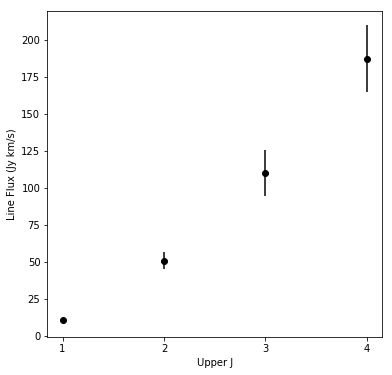

In [163]:
source.plot_sled()
# plt.ylim([0,20])

In [164]:
def translate_pyradex_to_Radex(data):
    pyradex_keys = ['t_ex', 'tau', 'freq', 'e_up', 'j_up', 
                    'j_low', 'pop_up', 'pop_low', 't_r']
    Radex_keys = ['Tex', 'tau', 'frequency', 'upperstateenergy', 'upperlevel', 
                  'lowerlevel', 'upperlevelpop', 'lowerlevelpop', 'T_B']
    unused_pyradex_keys = ['wave', 'flux_inu', 'flux_kkms']
    pyrad2Rad = {p:R for p,R in zip(pyradex_keys, Radex_keys)}
    for col in data.keys():
        if col not in pyrad2Rad:
            continue
        data.rename_column(col, pyrad2Rad[col])
    return data
    
def reduce_output_table(data, min_freq=None, max_freq=None, max_J=None):
    data["J_up"] = np.array(data["upperlevel"], dtype=int)
    if min_freq:
        data = data[data["frequency"] > min_freq]
    if max_freq:
        data = data[data["frequency"] < max_freq]
    if max_J:
        data = data[data["J_up"] <= max_J]
    return data

In [171]:
class ThermalModel(object):
    def __init__(self, mol, log_data=False):
        self.molecule = mol
        self.log_data = log_data

    def __call__(self, pars, Tbg=2.73, deltav=1.0, species=None, use_pyradex=True, **kwargs):
        # Note: pyradex is 5 times faster than Radex
        pars_kwds = self.interpret_pars(pars)
        if not species:
            species = self.molecule.lower()
        #if deltav != 1.0:
        #    raise Warning("Should not be changing deltav unless you know what you are doing.")
        if use_pyradex:
            data = self.run_radex(minfreq=50, maxfreq=1600, 
                                  velocity_gradient=deltav, tbg=Tbg, 
                                  species=species, use_pyradex=use_pyradex, **pars_kwds)
        else:
            data = self.run_radex(deltav=deltav, tbackground=Tbg, 
                                  species=species, use_pyradex=use_pyradex, **pars_kwds)
        return data
    
    def run_radex(self, use_pyradex=True, **kwargs):
        if use_pyradex:
            data = pyradex.pyradex(debug=False, **kwargs)
            data= translate_pyradex_to_Radex(data)
        else:
            self.radex = pyradex.Radex(debug=False, **kwargs)
            data = self.radex(return_table=True)
        return data
        
    def add_isotopologue(self, iso_mol, rel_abund, fixed_abund):
        # self.molecule = list(self.molecule) + [iso_mol]
        return
    
    def interpret_pars(self, pars):
        keys = self.parameter_names
        pars = [10**p if (self.log_data or getattr(self, "log_"+k)) else p for k,p in zip(keys,pars)]
        new_pars = {k:v for k,v in zip(keys,pars)}
        new_pars["collider_densities"] = {'H2': new_pars["density"]}
        new_pars.pop("density")
        return new_pars
    
    @property
    def parameter_names(self):
        raise NotImplementedError("""Accessing parameter_names from class ThermalModel.
                Should be accessing it from a child class.""")
    
    
class SingleTemperatureModel(ThermalModel):
    # Fit the temperature, density, column, and (optionally) filling factor.
    def __init__(self, mol, abund, norm=False, fit_ff=True, log_data=False, 
                 log_temperature=False, log_density=True, log_column=True):
        super().__init__(mol, log_data)
        self.abundance = abund
        self.norm = norm
        self.fit_ff = fit_ff
        self.log_temperature = log_temperature or log_data
        self.log_density = log_density or log_data
        self.log_column = log_column or log_data

    @property
    def parameter_names(self):
        # This should reflect the radex input names
        # Will want to check for the number of thermal components
        # Also need to consider isotopologues
        return ["temperature", "density", "column"]
    
    @property
    def all_parameter_names(self):
        names = self.parameter_names
        if self.fit_ff:
            names += ["log_ff"]
        return names
    
    @property
    def parameter_labels(self):
        # Need to add component number for 2 temperature fitting
        label_key = {"temperature": "T_{kin}", "density": "n_{H_2}", 
                     "column": "N/\Delta v", "log_ff": "\Phi"}
        labels = [f"$log({label_key[key]})$" for key in self.all_parameter_names]
        return labels

    @property
    def parameter_limits(self):
        # Note: All parameter limits are in log space
        return dict(temperature=dict(min=0.5, max=3.5),
                    density=dict(min=2, max=6.5),
                    column=dict(min=12, max=19),
                    log_ff=dict(min=-3, max=0))
    
    def _prior(self, pars):
        limits = self.parameter_limits
        
        names = self.parameter_names
        if self.fit_ff:
            names += ["log_ff"]
            
        for key,val in zip(names, pars):
            if (val < limits[key]["min"]) or (val > limits[key]["max"]):
                return REJECTED
        return 0
    
    def multinest_prior(self, cube, ndim, nparams):
        limits = self.parameter_limits
        
        names = self.parameter_names
        if self.fit_ff:
            names += ["log_ff"]
            
        for i,key in enumerate(names):
            zero_val = limits[key]["min"]
            multiplier = limits[key]["max"] - zero_val
            cube[i] = cube[i]*multiplier + zero_val
        return 
    
    @property
    def npar(self):
        # Temperature, density, column, filling factor
        return 3 + self.fit_ff

class TwoTemperature(ThermalModel):
    def __init__(self, mol):
        super().__init__(mol)
        raise NotImplementedError()

In [172]:
class RadexFitter(object):
    # Environment to combine the measured data with the RADEX model.
    # Provide tools for fitting the data.
    def __init__(self, data, model):
        self.data = data
        self.model = model
        
    def sled(self, pars, mol=None, return_intensity=False, **kwargs):
        # Run radex with a specified set of input parameters
        # Determine the SLED for the given molecule
        if not mol:
            mol = self.data.primary
            
        log_ff = 0
        if self.model.fit_ff:
            log_ff = pars[-1]
            pars = pars[:-1]

        kwargs.update(self.data.data_kwargs)
        max_J = max(self.data.sled[self.data.sled["mol"] == mol]["J_up"])
        flux = np.zeros(max_J)
        
        #for comp in self.num_components:
        radex_output = self.model(pars, **kwargs)
        radex_output = reduce_output_table(radex_output, max_J=max_J)
        
        tau = radex_output["tau"]
        if np.any((tau < 0) | (tau >= 100)):
            raise ValueError("Optical depth outside of allowable bounds.")

        freq = u.Quantity(radex_output["frequency"]/(1+self.data.z))
        peak = 1.04 * radex_output["T_B"] * 10**log_ff
        if return_intensity:
            # This is not actually a flux, it is an intensity
            flux += (peak * self.data.linewidth*_kmps).value
        else:
            flux += (kelvin_to_jy(peak, freq, self.data.beam_area) * self.data.linewidth*_kmps).value
        return flux
        
    def log_likelihood(self, pars, **kwargs):
        # See Kamenetzky et al. (2014, 2018) for the fitting routine and log_likelihood
        # https://arxiv.org/pdf/1803.07084.pdf
        # Want to minimize the negative log likelihood
        # -ln(L) = \Sigma_i 0.5\ln(2\pi) + \ln(\sigma_i) + 0.5(x_i-I_i(p))^2 \sigma_i^{-2}
        # x_i: measured line intensity of a single CO transition
        # sigma_i is the total uncertainty in a single transition
        # I_i(p) is the RADEX-modeled line intensity for that transition given p=[T_kin, n_H2, N_CO, Phi]
        lnprior = self.model._prior(pars)
        if lnprior != 0:
            return REJECTED

        lnL = 0
        for mol in list(self.data.molecules):
            mol_sled = self.data.sled[self.data.sled["mol"] == mol]
            J_up = np.unique(mol_sled["J_up"])
            
            try:
                flux = self.sled(pars, mol=mol, return_intensity=False, **kwargs)
            except ValueError:
                return -np.inf
            flux = flux[J_up-1]
            
            lnL += -np.sum((mol_sled["Flux"] - flux)**2/mol_sled["Flux_err"]**2 \
                          - np.log(mol_sled["Flux_err"]) + 0.5*np.log(2*np.pi))
        return lnL

    def mcmc(self, p0, nwalkers=100, num_processes=mp.cpu_count(), 
             burn_in=250, num_steps=750, **kwargs):
        pool = mp.Pool(num_processes)
        p0 = np.array(p0)
        ndim = len(p0)
        sampler = emcee.EnsembleSampler(nwalkers, ndim, self.log_likelihood, 
                                        kwargs=kwargs, pool=pool)
        pos = [p0 + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
        
        
        # Burn-in with 100 iteration
        pos, prob, state = sampler.run_mcmc(pos, burn_in)
        sampler.reset()
        sampler.run_mcmc(pos, num_steps)  # continue from burnt-in position "pos"
        return sampler
    
    def multinest(self, p0):
        # The parameters are derived quantities that depend on the input parameters (e.g. mass, luminosity)
        ndims = len(p0)
        loglike = self.log_likelihood
        prior = self.multinest_prior
        pymultinest.run(loglike, prior, ndims, n_params=ndims, importance_nested_sampling=False, 
                        resume=False, verbose=True, sampling_efficiency='model', n_live_points=500, 
                        outputfiles_basename='chains/1-', init_MPI=False)

In [173]:
# Example syntax
# model = ThermalModel(mol="CO")
model = SingleTemperatureModel(mol="CO", abund=2e-4, log_temperature=True)
# model.add_isotopologue("13CO", rel_abund=1/50, fixed_abund=True)

In [174]:
rf = RadexFitter(source, model)

In [175]:
tic = time()
sampler = rf.mcmc([np.log10(25), 4, 16.5, -1], nwalkers=30, 
                  num_processes=8, burn_in=500, num_steps=500)
toc = time()
print((toc-tic)/60)

3.090774981180827


Process ForkPoolWorker-77:
Process ForkPoolWorker-78:
Process ForkPoolWorker-76:
Process ForkPoolWorker-79:
Process ForkPoolWorker-80:
Process ForkPoolWorker-75:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multipro

In [176]:
class RadexAnalyzer(object):
    def __init__(self, fitter, sampler):
        self.fitter = fitter
        self.sampler = sampler
        self.results = self.sampler.chain.reshape(-1, self.fitter.model.npar)
        
    def corner_plot(self, truths=None):
        labels = self.fitter.model.parameter_labels
        fig = corner.corner(self.results, labels=labels, truths=truths)
        
    def show_walkers(self):
        nwalkers, nsteps, npar = self.sampler.chain.shape
        fig, axes = plt.subplots(npar, figsize=(8,8), sharex=True)
        for i in range(npar):
            for walker in range(nwalkers):
                axes[i].plot(self.chain[walker,:,i], "-k")
               
    @property
    def sled(self):
        return self.fitter.sled(self.best_fit)
    
    def plot_sled(self, plot_data=True, show_uncertainty=False, num_steps=100, **kwargs):
        if plot_data:
            self.fitter.data.plot_sled(**kwargs)
        flux = self.sled
        J = range(1, len(flux)+1)
        plt.plot(J, flux, "-r", lw=2)
        if show_uncertainty:
            for _ in range(num_steps):
                pars = self.results[np.random.randint(self.results.shape[0])]
                flux = self.fitter.sled(pars)
                plt.plot(J, flux, "-k", alpha=0.2)
        
    @property
    def mean(self):
        return self.results.mean(axis=0)
        
    @property
    def std(self):
        return self.results.std(axis=0)
    
    @property
    def percentiles(self):
        out = list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                       zip(*np.percentile(ra.results, [16, 50, 84], axis=0))))
        return np.array(out)
    
    @property
    def best_fit(self):
        return self.percentiles[:,0]
    
    @property
    def uncertainty(self):
        perr = self.percentiles[:,1]
        nerr = self.percentiles[:,2]
        return perr, nerr
    
    @property
    def chain(self):
        return self.sampler.chain

In [177]:
T_true = 73.8
n_true = 2.4e4
N_true = 4.1e17
Phi_true = 0.0072
log_data = np.log10([T_true, n_true, N_true, Phi_true])
print(log_data)
beam = (1.1331*5*4*u.arcsec**2).to(u.rad**2).value
data_true = model(log_data, Tbg=2.73*1.001)
flux = kelvin_to_jy(1.04*data_true["T_B"]*Phi_true, data_true["frequency"]/1.001, beam)*120*_kmps
flux[:6]

[ 1.86805636  4.38021124 17.61278386 -2.1426675 ]


<Quantity [ 11.10149403,  51.05751346, 110.16911458, 186.97953531,
           276.52653127, 366.56615552] Jy km / s>

In [178]:
ra = RadexAnalyzer(rf, sampler)

In [179]:
ra.fitter.data = source

In [180]:
print(ra.best_fit)
print(*ra.uncertainty)

[ 1.97491985  4.99785858 18.00550254 -2.24312347]
[0.30105546 1.07464778 0.58359508 0.36127909] [0.3514695  1.36185447 0.73809532 0.30300416]


In [182]:
ra.sled

array([ 12.77479558,  54.4764819 , 119.18060984, 205.81812636])

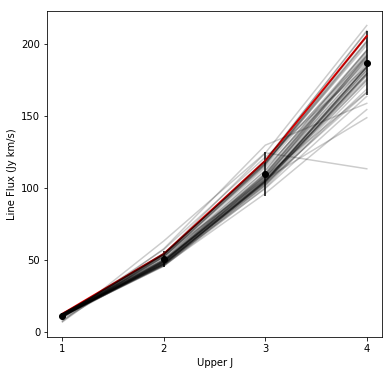

In [183]:
# source.plot_sled()
ra.plot_sled(show_uncertainty=True, num_steps=50)

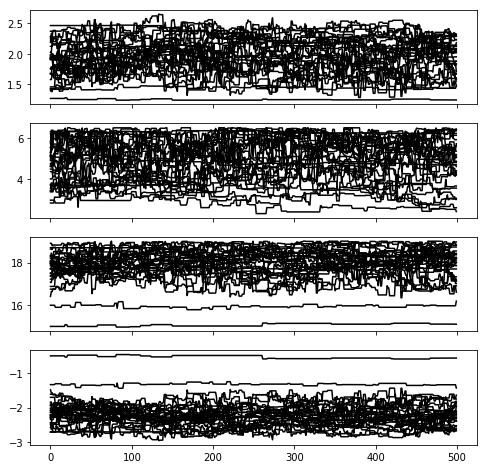

In [185]:
ra.show_walkers()

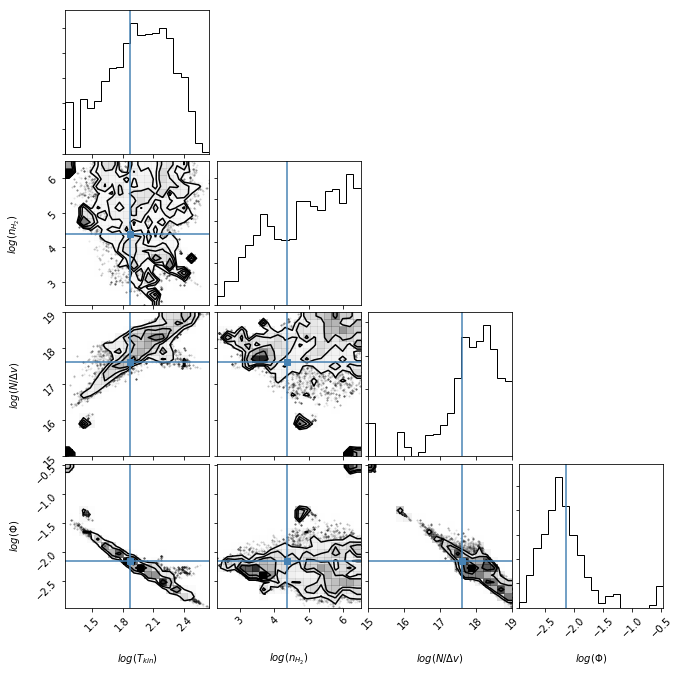

In [186]:
ra.corner_plot(truths=np.log10([T_true, n_true, N_true, Phi_true]))

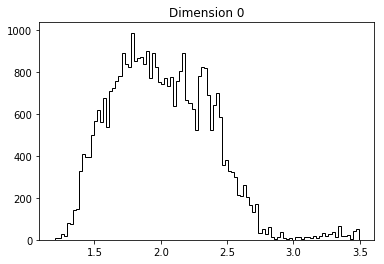

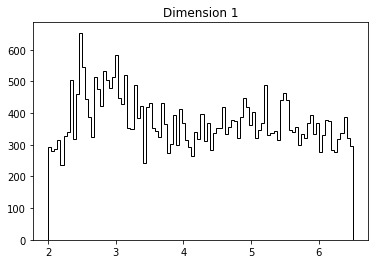

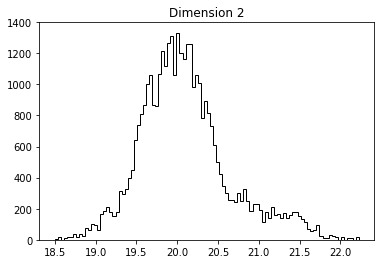

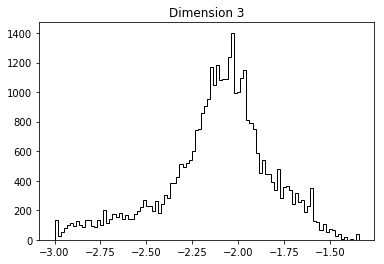

In [39]:
for i in range(4):
    plt.figure()
    plt.hist(ra.results[:,i], 100, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))


In [12]:
model.radex.abundance.decompose()

<Quantity 3.24077929e-06>

## Use Cases

1) SLED fit for a single molecule. Fix the CO/H2 abundance and fit all other parameters.

2) SLED for CO+13CO. Fix the CO/H2 and 13CO/12CO abundances. Tie T, n, N between the two components.

3) Two-component modelling. One warm and one cold component.

4) CO+13CO SLED with multiple 13CO lines. Free the 13CO/12CO abundance ratio. Also allow it to be fixed to the specified ratio.

5) Two-component modelling for multiple isotopologues.

6) Allow for completely different molecules to be modelled simultaneously. This is a very distant goal.

## Summary of Use Cases:

1) Regular single temperature fit of T, n, N.

2) Two component fitting.

3) Add an isotopologue to either of the above. Either with fixed abundance or allow it to vary.

4) Add a different molecule that shares temperature and H2 density, but not column/abundance. This is a *very* distant goal.

## Everything below this markdown is older code that has not yet been incorporated.

In [18]:
list([2])

[2]

In [5]:
class radex(object):
    '''
    ***This is from the ALMA proposal. Not intended to be used here.***
    Note: column is defined per unit velocity, which is assumed to be 1 km/s.
    Will need to assume a linewidth in order to use the true gas column density.'''
    
    def __init__(self, z, **kawrgs):
        self.z = z
        self.Tbg = 2.73*(1+z)
        self.R = pyradex.Radex(tbackground=self.Tbg, **kawrgs)
        self.R.run_radex()
       
    @classmethod
    def temperature_column(cls, z, column=1e18, temperature=25, 
                           abundance=3e-4, species="co"):
        return cls(z, species=species, abundance=abundance, 
                   temperature=temperature, column=column)
        
    def update(self, **kwargs):
        for key in kwargs:
            setattr(self.R, key, kwargs[key])
        self.R.run_radex(silent=True, reuse_last=False, reload_molfile=True)
    
    @property
    def normalized_SCO(self):
        SCO_norm = self.normalized_ICO*J*J
        return SCO_norm
    
    @property
    def normalized_ICO(self):
        #Jmax=6
        J = np.arange(1, Jmax+1)
        ICO = self.R.source_line_brightness_temperature[:Jmax]
        ICO_norm = ICO/ICO[0]
        return ICO_norm
    
    @property
    def conversion_factor(self):
        '''X_CO = N(H_2)/W(CO)
           N(H_2) = N(CO)/[CO/H2]
           W(CO) = T_B*FWHM / 0.94
           Columns are already per unit linewidth, so we can 
           exclude that factor.
        '''
        abund = self.R.abundance
        NCO = self.R.column   # cm-2 / (km/s)
        NH2 = (NCO/abund).to(1/u.cm**2)
        T10 = self.R.T_B[0]   # K
        WCO = T10 * self.R.deltav
        #WCO = T10 * linewidth/0.94  # K km/s
        XCO = (NH2/WCO).to(1/(u.cm**2*u.km/u.s*u.K))  # cm-2 / (km/s) / K
        return XCO.value/XCOgal

In [ ]:
try:
    R.update(temperature=temperature, column=column)
except NameError:
    R = radex.temperature_column(z, temperature=temperature, column=column)

In [ ]:
########################
### From pyradexnest ###
########################

dat1=pyradex.pyradex(minfreq=1, maxfreq=1600,
                  temperature=np.power(10,cube[1]), column=np.power(10,cube[2]), 
                  collider_densities={'H2':np.power(10,cube[0])},
                  tbg=meas['tbg'], species=meas['head']['mol'], velocity_gradient=1.0, debug=False,
                  return_dict=True)
# dat['J_up'] returned as strings; this is fine for CO...
jup1=np.array(map(float,dat1['J_up']))
model1=np.array(map(float,dat1['FLUX_Kkms']))*np.power(10,cube[3])
tau1=np.array(map(float,dat1['TAU']))

# Check for convergence
if dat1['niter']==['****']: return -2e100

# At this time it is too slow to use this.
#R = pyradex.Radex(collider_densities={'h2':np.power(10,cube[0])}, 
#     temperature=np.power(10,cube[1]), column=np.power(10,cube[2]),
#     tbackground=meas['tbg'],species=meas['head']['mol'],deltav=1.0,debug=False)
#niter=R.run_radex(validate_colliders=False)
#model1=1.064575*R.T_B*np.power(10,cube[3]) # Integrating over velocity, and Filling Factor
#model1=model1.value # Hatred of units in my way
#tau1=R.tau
#jup1=R.upperlevelindex        
#cube[ndim]=np.sum(R.source_brightness_beta) # luminosity; not correct units yet.